# Pressure - $\eta$ transforms
Find optimal parameters for transforming Asilomar Small-Scale Array pressure measurements to sea-surface elevation $\eta$. Test both regular linear transfer function and the $\kappa_\mathrm{rms}$-based methods of Martins et al. (2021, JPO).

In [23]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import scipy.stats as stats
from scipy import signal
from scipy.io import loadmat
from tqdm.notebook import tqdm
import cmocean
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
from cmcrameri import cm
from PyPDF2 import PdfFileMerger, PdfFileReader
# Interactive plots
%matplotlib widget 

from roxsi_pyfuns import coordinate_transforms as rpct
from roxsi_pyfuns import transfer_functions as rptf
from roxsi_pyfuns import wave_spectra as rpws

# Paths
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray/'
data_root = os.path.join(rootdir, 'Signatures', 'Level1')
bathydir = os.path.join(rootdir, 'Bathy')
figdir = os.path.join(data_root, 'img')


Test different transfer function parameters for pressure-$\eta$ reconstruction and compare against acoustic surface track (AST) signal from Nortek Signature 1000 ADCPs around the SSA rock.

Date:  2022-06-28 00:00:00


KeyboardInterrupt: 

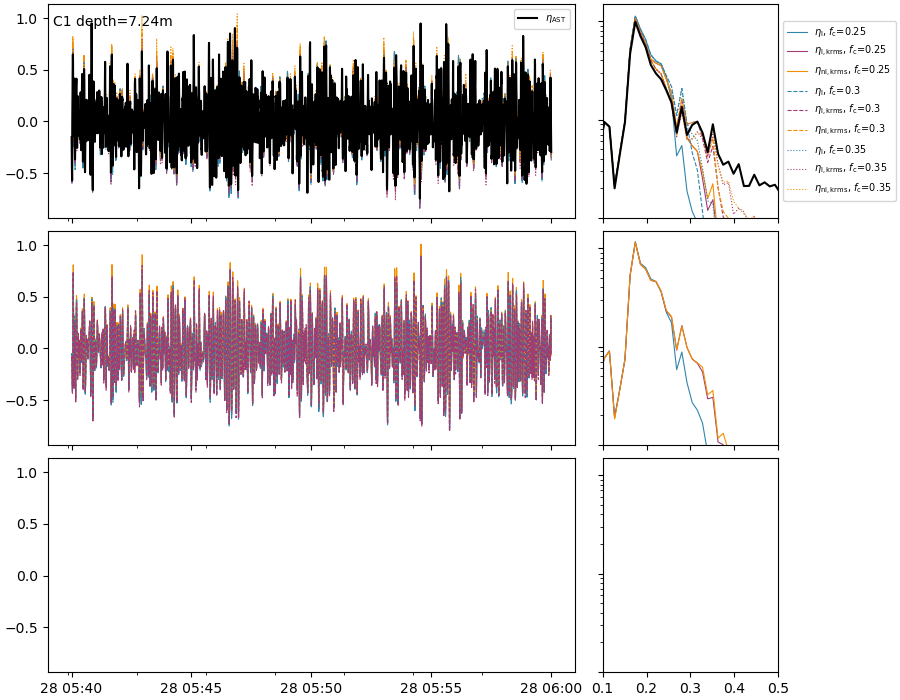

In [34]:
mids = ['C1', 'C3', 'C6'] # Mooring IDs
sers = ['103088', '103094', '103110'] # Serial numbers

# Define segment timestamps
t0 = pd.Timestamp('2022-06-28 00:00') # start date
t1 = pd.Timestamp('2022-06-29 00:00') # start date
nm = 20 # time series length (number of minutes)
tfreq = '{}T'.format(nm) # Time step between timestamps in date range
date_range = pd.date_range(t0, t1, freq='1D')

# K_rms transformation parameters
tail_method = 'constant'
fix_ends = False
fmax = 1.0

for date in date_range:
    print('Date: ', str(date))
    ds = ''.join(str(date.date()).split('-')) # Datestr in format yyyymmdd
    # Split date into nm-minute segments
    rec_range = pd.date_range(date, date+pd.Timedelta(days=1), freq=tfreq)
    # Iterate over nm-minute segments and transform pressure -> eta and plot
    for cnt, t0s in enumerate(rec_range):
        t1s = t0s + pd.Timedelta(minutes=nm)
        # Initialize figure
        fig, axes = plt.subplots(figsize=(9,7), nrows=3, ncols=2, sharex='col', sharey='col',
                                gridspec_kw={'width_ratios': [3, 1]}, constrained_layout=True)
        # Iterate over mooring IDs and serial numbers
        for i, (mid, ser) in enumerate(zip(mids, sers)):
            # print('Mooring ID: ', mid)
            # Signature velocity netcdf directory
            veldir = os.path.join(data_root, '{}'.format(ser)) 
            # Check if output csv file exists
            csvdir = os.path.join(veldir, 'p2eta')
            if not os.path.isdir(csvdir):
                os.mkdir(csvdir)
            fn_csv = os.path.join(csvdir, 'p2eta_{}_{}_{:03d}_tail_{}.csv'.format(
                ser, ds, cnt, tail_method))
            if not os.path.isfile(fn_csv):
                # List netcdf files in veldir
                fns_v = sorted(glob.glob(os.path.join(veldir, 'Asilomar_*.nc')))
                if str((t0s - pd.Timedelta(minutes=nm/2)).date()) != str(t0s.date()):
                    # Combine current and previous dates
                    t00s = (t0s - pd.Timedelta(minutes=nm/2)).date() # Previous date
                    # Read Signature velocity dataset for current date
                    datestr = '{}{:02d}{:02d}'.format(t0s.year, t0s.month, t0s.day)
                    fn_sig = [f for f in fns_v if datestr in f]
                    # Read current date's dataset
                    dsc = xr.decode_cf(xr.open_dataset(fn_sig[0], decode_coords='all'))
                    # Read Signature velocity dataset for previous date
                    datestr0 = '{}{:02d}{:02d}'.format(t00s.year, t00s.month, t00s.day)
                    fn_sig0 = [f for f in fns_v if datestr0 in f]
                    # Read previous date's dataset
                    ds0 = xr.decode_cf(xr.open_dataset(fn_sig0[0], decode_coords='all'))
                    # Concatenate current+previous datasets
                    ds = xr.concat([ds0, dsc], dim='time')
                elif str((t1s + pd.Timedelta(minutes=nm/2)).date()) != str(t1s.date()):
                    # Combine current and following dates
                    t11s = (t1s + pd.Timedelta(minutes=nm/2)).date() # Following date
                    # Read Signature velocity dataset for current date
                    datestr = '{}{:02d}{:02d}'.format(t0s.year, t0s.month, t0s.day)
                    fn_sig = [f for f in fns_v if datestr in f]
                    # Read current date's dataset
                    dsc = xr.decode_cf(xr.open_dataset(fn_sig[0], decode_coords='all'))
                    # Read Signature velocity dataset for following date
                    datestr1 = '{}{:02d}{:02d}'.format(t11s.year, t11s.month, t11s.day)
                    fn_sig1 = [f for f in fns_v if datestr1 in f]
                    # Read following date's dataset
                    ds1 = xr.decode_cf(xr.open_dataset(fn_sig1[0], decode_coords='all'))
                    # Concatenate current+following datasets
                    ds = xr.concat([dsc, ds1], dim='time')
                else:
                    # Read Signature velocity dataset for current date
                    datestr = '{}{:02d}{:02d}'.format(t0s.year, t0s.month, t0s.day)
                    fn_sig = [f for f in fns_v if datestr in f]
                    # In some cases, 30.6 and 1.7 dates are combined into one netcdf file
                    sk = np.logical_and(np.logical_or(mid=='C3', mid=='C6'), 
                                        str(t0s.date())=='2022-06-30')
                    if not sk:
                        ds = xr.decode_cf(xr.open_dataset(fn_sig[0], decode_coords='all'))
                    else:
                        fn_sig = [f for f in fns_v if '20220701' in f]
                        ds = xr.decode_cf(xr.open_dataset(fn_sig[0], decode_coords='all'))
                # Take requested segment from dataset
                seg = ds.sel(time=slice(t0s, t1s)).copy() # Segment slice
                # Directional wave spectra
                # Use AST and pressure for spectra
                eta_ast = seg.ASTd_eta.values # AST
                eta_hyd = seg.eta_hyd.values # hydrostatic surface
                z_hyd = seg.z_hyd.values # hydrostatic pressure head
                time_index = seg.time.values # Time index for dataframe
                # Save eta products to dataframe
                dfe = pd.DataFrame(data={'eta_hyd': eta_hyd, 'eta_ast': eta_ast},
                                index=time_index)
                # Estimate AST and hydrostatic spectra
                dss = rpws.spec_uvz(z=eta_ast, fs=4, wsec=256, fmerge=3)
                dssh = rpws.spec_uvz(z=eta_hyd, fs=4, wsec=256, fmerge=3)
                dss['Ehh'] = (['freq'], dssh.Ezz.values)
                # Reconstruct eta from pressure for different cut-off frequencies
                fcs = [0.25, 0.3, 0.35] # cut-off freqs (Hz)
                lss = ['-', '--', ':'] # Linestyles for fc values
                for fi,fc in enumerate(fcs):
                    # Initialize TRF object
                    trf = rptf.TRF(fs=4, zp=0.3)
                    # Regular linear reconstruction (returns depth)
                    z_lin = trf.p2z_lin(z_hyd, fmax=fc)
                    depth = np.mean(z_lin)
                    eta_lin = z_lin - depth
                    # Compute bispectrum and use it to get K_rms
                    dsb = rpws.bispectrum(eta_hyd, fs=4, h0=depth, return_krms=True)
                    krms = dsb.k_rms.values
                    f_krms = dsb.freq1.values
                    # (Non)linear K_rms reconstructions
                    eta_lin_krms, eta_nl_krms = trf.p2eta_krms(eta_hyd, h0=depth, fc=fc, 
                        fcmax_allowed=fc, f_krms=f_krms, krms=krms, return_nl=True, fmax=fmax, 
                        fp=(1 / dss.Tp_Y95.item()), fix_ends=fix_ends, tail_method=tail_method)
                    # Fix end points with overlapping reconstructions
                    t0ob = t0s - pd.Timedelta(minutes=(nm/2)) # half period before t0
                    t1ob = t0s + pd.Timedelta(minutes=(nm/2)) # half period before t1
                    # Get hydrostatic signal 
                    seg0 = ds.sel(time=slice(t0ob, t1ob)).copy() # Overlap segment slice
                    times0 = seg0.time.values
                    z_hyd0 = seg0.z_hyd.values
                    eta_hyd0 = z_hyd0 - np.mean(z_hyd0)
                    # Reconstruct linear
                    z_lin0 = trf.p2z_lin(z_hyd0, fmax=fc)
                    eta_lin0 = z_lin0 - depth
                    # Reconstruct (non)linear K_rms
                    eta_lin_krms0, eta_nl_krms0 = trf.p2eta_krms(eta_hyd0, h0=depth, fc=fc, 
                        fcmax_allowed=fc, f_krms=f_krms, krms=krms, return_nl=True, fmax=fmax, 
                        fp=(1 / dss.Tp_Y95.item()), fix_ends=fix_ends, tail_method=tail_method)
                    # Also get half period after
                    t0oa = t1s - pd.Timedelta(minutes=(nm/2)) # half period before t0
                    t1oa = t1s + pd.Timedelta(minutes=(nm/2)) # half period before t1
                    # Get hydrostatic signal 
                    seg1 = ds.sel(time=slice(t0oa, t1oa)).copy() # Overlap segment slice
                    times1 = seg1.time.values
                    z_hyd1 = seg1.z_hyd.values
                    eta_hyd1 = z_hyd1 - np.mean(z_hyd1)
                    # Reconstruct linear
                    z_lin1 = trf.p2z_lin(z_hyd1, fmax=fc)
                    eta_lin1 = z_lin1 - depth
                    # Reconstruct (non)linear K_rms
                    eta_lin_krms1, eta_nl_krms1 = trf.p2eta_krms(eta_hyd1, h0=depth, fc=fc, 
                        fcmax_allowed=fc, f_krms=f_krms, krms=krms, return_nl=True, fmax=fmax, 
                        fp=(1 / dss.Tp_Y95.item()), fix_ends=fix_ends, tail_method=tail_method)
                    # Make dataframes and merge end points
                    dfm0 = pd.DataFrame(data={'eta_lin': eta_lin0, 
                                            'eta_lin_krms':eta_lin_krms0, 
                                            'eta_nl_krms':eta_nl_krms0, 
                                            },
                                        index=times0)
                    dfm0.index = dfm0.index.rename('time')
                    dfm = pd.DataFrame(data={'eta_lin': eta_lin, 
                                            'eta_lin_krms':eta_lin_krms, 
                                            'eta_nl_krms':eta_nl_krms, 
                                            },
                                        index=time_index)
                    dfm.index = dfm.index.rename('time')
                    dfm1 = pd.DataFrame(data={'eta_lin': eta_lin1, 
                                            'eta_lin_krms':eta_lin_krms1, 
                                            'eta_nl_krms':eta_nl_krms1, 
                                            },
                                        index=times1)
                    dfm1.index = dfm1.index.rename('time')
                    # Merge left and right dataframes with original (middle)
                    dfl = dfm.join(dfm0, on='time', how='left', lsuffix='_o', rsuffix='_l')
                    dfr = dfm.join(dfm1, on='time', how='left', lsuffix='_o', rsuffix='_r')
                    # Use first 100 samples from left dataframe to fix start edge effects
                    eta_lin_m = np.concatenate((dfl['eta_lin_l'].iloc[:100], 
                                                dfl['eta_lin_o'].iloc[100:]))
                    eta_lin_krms_m = np.concatenate((dfl['eta_lin_krms_l'].iloc[:100], 
                                                    dfl['eta_lin_krms_o'].iloc[100:]))
                    eta_nl_krms_m = np.concatenate((dfl['eta_nl_krms_l'].iloc[:100], 
                                                    dfl['eta_nl_krms_o'].iloc[100:]))
                    # Use last 100 samples from right dataframe to fix end edge effects
                    eta_lin_m = np.concatenate((eta_lin_m[:-100], dfr['eta_lin_r'].iloc[-100:]))
                    eta_lin_krms_m = np.concatenate((eta_lin_krms_m[:-100], 
                                                    dfr['eta_lin_krms_r'].iloc[-100:]))
                    eta_nl_krms_m = np.concatenate((eta_nl_krms_m[:-100], 
                                                    dfr['eta_nl_krms_r'].iloc[-100:]))
                    # Save reconstructions to dataframe
                    dfe['etal-{}'.format(fc)] = eta_lin_m
                    dfe['etalk-{}'.format(fc)] = eta_lin_krms_m
                    dfe['etank-{}'.format(fc)] = eta_nl_krms_m
                    # Estimate spectra
                    dssl = rpws.spec_uvz(eta_lin_m, fs=4)
                    dss['etal-{}'.format(fc)] = (['freq'], dssl.Ezz.values)
                    dsslk = rpws.spec_uvz(eta_lin_krms_m, fs=4)
                    dss['etalk-{}'.format(fc)] = (['freq'], dsslk.Ezz.values)
                    dssnk = rpws.spec_uvz(eta_nl_krms_m, fs=4)
                    dss['etank-{}'.format(fc)] = (['freq'], dssnk.Ezz.values)
                    # Plot reconstructed eta and spectra
                    dfe['etal-{}'.format(fc)].plot(ax=axes[i,0], color='#2E86AB', linestyle=lss[fi],
                                                label='_', linewidth=0.8)
                    dfe['etalk-{}'.format(fc)].plot(ax=axes[i,0], color='#A23B72', linestyle=lss[fi],
                                                    label='_', linewidth=0.8)
                    dfe['etank-{}'.format(fc)].plot(ax=axes[i,0], color='#F18F01', linestyle=lss[fi],
                                                    label='_', linewidth=0.8)
                    # Spectra
                    dss['etal-{}'.format(fc)].plot(ax=axes[i,1], color='#2E86AB', linestyle=lss[fi],
                        label=r'$\eta_\mathrm{l}$, $f_\mathrm{c}$'+'={}'.format(fc),
                        linewidth=0.8,
                        )
                    dss['etalk-{}'.format(fc)].plot(ax=axes[i,1], color='#A23B72', linestyle=lss[fi],
                        label=r'$\eta_\mathrm{l, krms}$, $f_\mathrm{c}$'+'={}'.format(fc),
                        linewidth=0.8,
                        )
                    dss['etank-{}'.format(fc)].plot(ax=axes[i,1], color='#F18F01', linestyle=lss[fi],
                        label=r'$\eta_\mathrm{nl, krms}$, $f_\mathrm{c}$'+'={}'.format(fc),
                        linewidth=0.8,
                        )
                # Also plot AST eta and spectrum
                dfe['eta_ast'].plot(ax=axes[i,0], color='k', label=r'$\eta_\mathrm{AST}$')
                dss.Ezz.plot(ax=axes[i,1], color='k')
                # Annotate mooring ID and depth
                axes[i,0].annotate('{} depth={:.2f}m'.format(mid, depth), xy=(0.01, 0.9), 
                                xycoords='axes fraction', fontsize=10)
                # Legend on top row
                axes[0,1].legend(ncols=1, fontsize=7, loc='center left', bbox_to_anchor=(1,0.5))
                # AST legend in 0,0
                axes[0,0].legend(ncols=1, fontsize=7, loc='upper right')
                # Set spectrum plot axes to semilogy scale and zoom in to mid frequencies
                axes[i,1].set_yscale('log')
                axes[i,1].set_xlim([0.1, 0.5])
                axes[i,1].set_xticks([0.1, 0.2, 0.3, 0.4, 0.5])
                axes[i,1].set_ylim([0.01, dss.Ezz.max() + 0.5])
            axes[0,0].set_title('{}-{}'.format(str(t0s), str(t1s.time())))

            plt.tight_layout()
            # Figure filename
            fn_fig = os.path.join(figdir, 'p2eta_comp_{}_{:03d}_tail_{}.pdf'.format(
                ds, cnt, tail_method))
            if not os.path.isfile(fn_fig):
                plt.savefig(fn_fig, bbox_inches='tight', dpi=300)
            plt.close()

    raise ValueError('Stop')



'20220628'